# Santander 

This is a very simple kernel for the Santander competition featuring the following:
* interaction features based on those features that show correlations with `target`;
* re-sampling of the data to compensate for the imbalanced nature of the training data set using `imblearn`;
* comparison of and modeling with `lightgbm` (using the `sklearn` interface) and a simple ridge classifier;
* use of `GridSearchCV` and `sklearn.pipeline` to find the best-fit parameters;
* no magic.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Data Exploration

## Feature completeness and data types

In [2]:
train.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 202 columns):
ID_code    200000 non-null object
target     200000 non-null int64
var_0      200000 non-null float64
var_1      200000 non-null float64
var_2      200000 non-null float64
var_3      200000 non-null float64
var_4      200000 non-null float64
var_5      200000 non-null float64
var_6      200000 non-null float64
var_7      200000 non-null float64
var_8      200000 non-null float64
var_9      200000 non-null float64
var_10     200000 non-null float64
var_11     200000 non-null float64
var_12     200000 non-null float64
var_13     200000 non-null float64
var_14     200000 non-null float64
var_15     200000 non-null float64
var_16     200000 non-null float64
var_17     200000 non-null float64
var_18     200000 non-null float64
var_19     200000 non-null float64
var_20     200000 non-null float64
var_21     200000 non-null float64
var_22     200000 non-null float64
var_23     20000

In [3]:
test.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 201 columns):
ID_code    200000 non-null object
var_0      200000 non-null float64
var_1      200000 non-null float64
var_2      200000 non-null float64
var_3      200000 non-null float64
var_4      200000 non-null float64
var_5      200000 non-null float64
var_6      200000 non-null float64
var_7      200000 non-null float64
var_8      200000 non-null float64
var_9      200000 non-null float64
var_10     200000 non-null float64
var_11     200000 non-null float64
var_12     200000 non-null float64
var_13     200000 non-null float64
var_14     200000 non-null float64
var_15     200000 non-null float64
var_16     200000 non-null float64
var_17     200000 non-null float64
var_18     200000 non-null float64
var_19     200000 non-null float64
var_20     200000 non-null float64
var_21     200000 non-null float64
var_22     200000 non-null float64
var_23     200000 non-null float64
var_24     200

Inventory:
* `train`: 200 features with continuous data + binary `target` feature + `ID_code` column; all features complete, no missing data
* `test`: 200 features with continuous data + `ID_code` column; all features complete, no missing data

Feature labels are **anonymized**.

What is the distribution of the data in each feature?

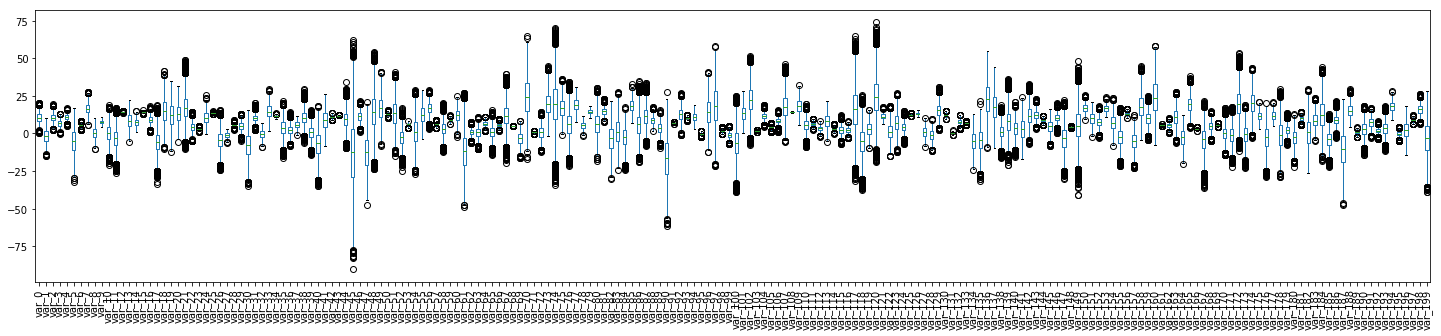

In [4]:
f, ax = plt.subplots(figsize=(25,5))

train.drop(['target', 'ID_code'], axis=1).plot.box(ax=ax, rot=90)

In general, all features are **well-behaved**, most box-plot bars are symmetric, so **distributions are more or less symmetric**, as well. 

Is the training data set balanced?

In [5]:
len(train.loc[train.target == 1])/len(train)

0.10049

No, only about 10% of the training set have `target == 1` - the training **data set is highly imbalanced**. Will have to use resampling in the modeling!

## Correlation analysis

Check for correlations between individual features:

In [6]:
r2 = pd.concat([train.drop(['target', 'ID_code'], axis=1), test.drop('ID_code', axis=1)]).corr()**2
r2 = np.tril(r2, k=-1)  # remove upper triangle and diagonal
r2[r2 == 0] = np.nan # replace 0 with nan

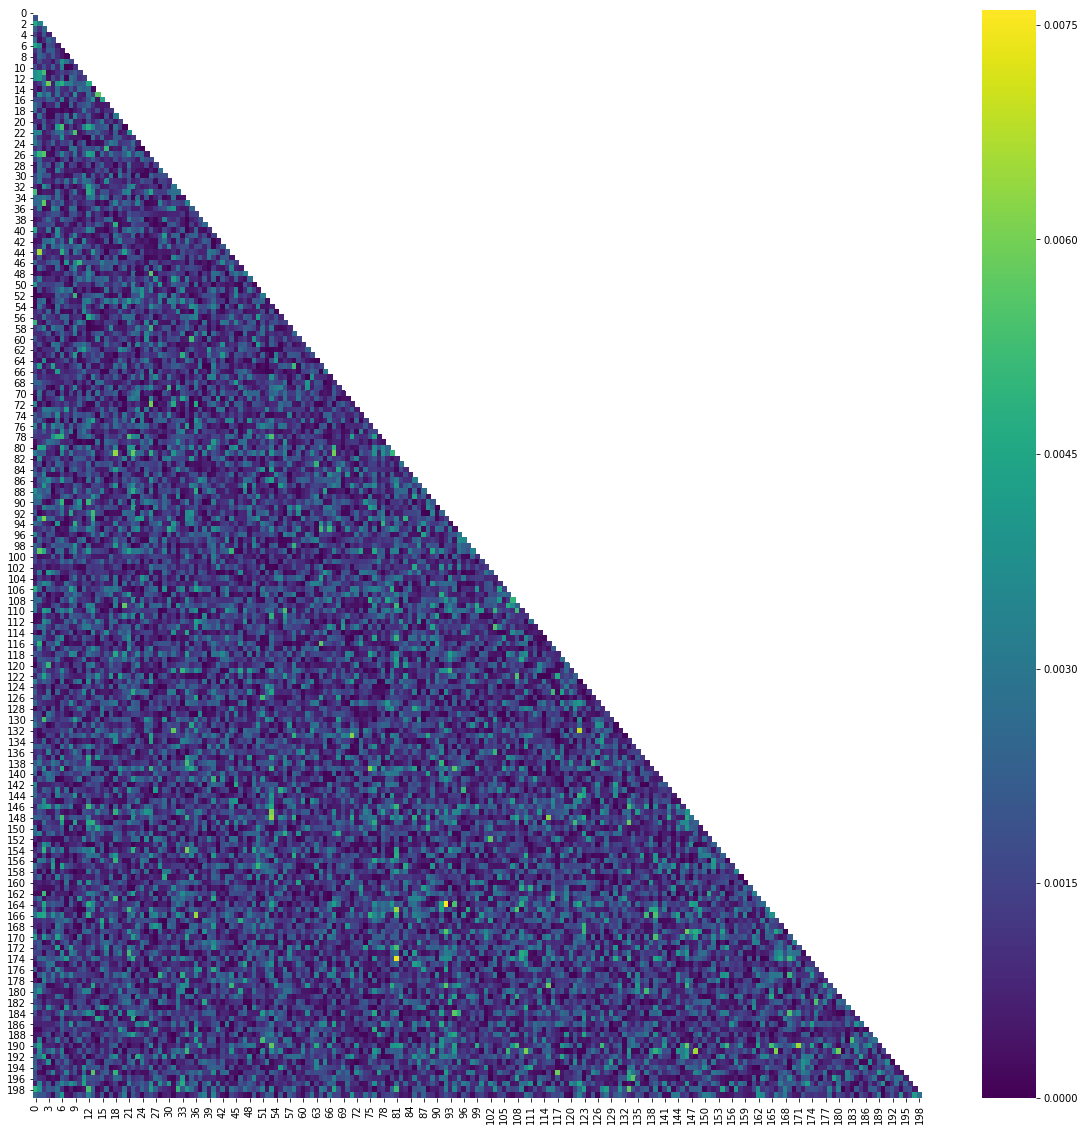

In [7]:
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(np.sqrt(r2), annot=False,cmap='viridis', ax=ax)

Explained **absolute variation ($\sqrt{r^2}$) between individual features is small** (< 1%). All features seem to be highly independent from each other.

What about correlations between features and `target`?

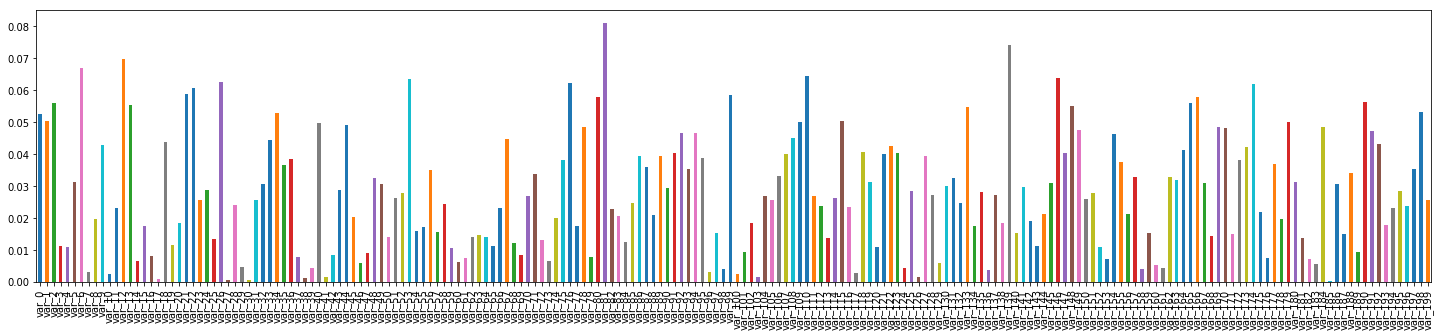

In [8]:
target_r2 = train.drop(['ID_code', 'target'], axis=1).corrwith(train.target).agg('square')

f, ax = plt.subplots(figsize=(25,5))
target_r2.agg('sqrt').plot.bar(ax=ax)

Explained absolute variation ($\sqrt{r^2}$) up to 8%. Few features seem to stick out in terms of correlation with `target`.

## Feature Engineering

Not much is known about the features, except for what is listed above. This makes feature engineering hard. In a long (and blind) shot, we try the following:

Extract the top $n$ features with $\sqrt{r^2} \geq 0.048$ and create second-degree interaction features based on those. These polynomial features will be added in the modeling step.

The value of 0.048 was derived by maximizing the `roc-auc` for the ridge regression model below. Interestingly, adding these interaction features to the `lightgbm` model does not improve its predictive power. 

In [9]:
top = target_r2.loc[np.sqrt(target_r2) > 0.048].index
top

Index(['var_0', 'var_1', 'var_2', 'var_6', 'var_12', 'var_13', 'var_21',
       'var_22', 'var_26', 'var_34', 'var_40', 'var_44', 'var_53', 'var_76',
       'var_78', 'var_80', 'var_81', 'var_99', 'var_109', 'var_110', 'var_115',
       'var_133', 'var_139', 'var_146', 'var_148', 'var_165', 'var_166',
       'var_169', 'var_174', 'var_179', 'var_184', 'var_190', 'var_198'],
      dtype='object')

In [10]:
from sklearn.preprocessing import PolynomialFeatures

polyfeat_train = pd.DataFrame(PolynomialFeatures(2).fit_transform(train[top]))
polyfeat_test = pd.DataFrame(PolynomialFeatures(2).fit_transform(test[top]))

# Modeling

We use `lightgbm` and a simple ridge regression as representatives of tree-based and linear models, respectively.

Given the highly imbalanced nature of the training data set, we apply a resampler for balancing. We tested `RandomUnderSampler` and `RandomOverSampler` from the `imblearn` module and found that the latter performs better with both models.**

In [11]:
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [12]:
# additional imports
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

## lightgbm

In [33]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

lgbpipe = Pipeline([('resample', RandomOverSampler(random_state=42)), ('model', lgb.LGBMClassifier(random_state=42, objective='binary', metric='auc', 
                                                                                                   boosting='gbdt', verbosity=1,
                                                                                                   tree_learner='serial'))])

params = {    
    "model__max_depth" : [20],
    "model__num_leaves" : [30],
    "model__learning_rate" : [0.1],
    "model__subsample_freq": [5],
    "model__subsample" : [0.3],
    "model__colsample_bytree" : [0.05],
    "model__min_child_samples": [100],
    "model__min_child_weight": [10],
    "model__reg_alpha" : [0.12],
    "model__reg_lambda" : [15.5],
    "model__n_estimators" : [600]
    }

# previous best-fit gridsearch parameters and results
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 100, 'model__num_leaves': 30, 'model__reg_alpha': 0.1, 'model__reg_lambda': 10, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8735588789424164
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 400, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 0.2, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8915905852982839
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 500, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 0.2, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8923071245054173
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 0.2, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8925518240005254
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 550, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 0.2, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8924978701504809
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 15, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8941148812638564
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.5, 'model__reg_lambda': 12, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8938169988416745
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.3, 'model__reg_lambda': 15, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8941407236592286
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.2, 'model__reg_lambda': 15, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8938875270813017
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.2, 'model__reg_lambda': 15, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8938875270813017
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 15.5, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8943001048082946
# {'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 15.2, 'model__subsample': 0.3, 'model__subsample_freq': 5}
# 0.8939732044413886

lgbgrid = GridSearchCV(lgbpipe, param_grid=params, cv=10, scoring='roc_auc')
lgbgrid.fit(train.drop(['ID_code', 'target'], axis=1), train.target)

print(lgbgrid.best_params_)
print(lgbgrid.best_score_)

{'model__colsample_bytree': 0.05, 'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 10, 'model__n_estimators': 600, 'model__num_leaves': 30, 'model__reg_alpha': 0.12, 'model__reg_lambda': 15.5, 'model__subsample': 0.3, 'model__subsample_freq': 5}
0.8943001048082946


## Ridge regression

Using a `RobustScaler`, which is probably not even necessary since the features are rather well-behaved.

In [14]:
from sklearn.linear_model import RidgeClassifier

ridgepipe = Pipeline([('resample', RandomOverSampler(random_state=42)), ('scaler', RobustScaler()), ('model', RidgeClassifier(random_state=42))])

params = {'model__alpha': [1.0]} # between 0.5 and 2; best-fit so far: 1
 
ridgegrid = GridSearchCV(ridgepipe, param_grid=params, cv=3, scoring='roc_auc')
ridgegrid.fit(pd.concat([train.drop(['ID_code', 'target'], axis=1), polyfeat_train], axis=1, join='inner'), train.target)

print(ridgegrid.best_params_)
print(ridgegrid.best_score_)

{'model__alpha': 1.0}
0.8734118924904035


Comparing the results between `lightgbm` and the ridge regression classifier, the former clearly wins despite the additional interaction features that are used in the ridge regression model. 

# Submission

In [15]:
pred = pd.DataFrame(lgbgrid.predict_proba(test.drop(['ID_code'], axis=1))[:, -1], columns=['target'], index=test.loc[:, 'ID_code'])
pred.to_csv('submission.csv', index=True)

In [16]:
!head submission.csv

ID_code,target
test_0,0.3807131215583003
test_1,0.5724165769926804
test_2,0.5896878360333441
test_3,0.5750929300637335
test_4,0.4439222372784203
test_5,0.23932475239375753
test_6,0.2733344630008094
test_7,0.5565037175172928
test_8,0.14452180375776488


In [17]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


# Changelog
1. initial commit: cv score: 0.89, public score: 0.80
2. explored a larger parameter space for `lightgbm` and force higher regularization parameters to prevent overfitting; submit probabilities instead of classes: cv score: 0.873, public score: 0.870
3. some more fine-tuning of the model: cv score: 0.894 -- final submission